In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(0)


#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device

In [2]:
DATA_PATH = 'data/keypoint.csv'
MODEL_PATH = 'models/model.pth'
LRNG_CURVE_PATH = 'models/learning_curve.png'
MODEL_ARCH_PATH = 'models/model_architecture.pth'

In [3]:

data = pd.read_csv(DATA_PATH, header = None)
print(data.shape)
data[0].value_counts(normalize = True)

(1229, 43)


8     0.073230
13    0.070789
10    0.064280
14    0.063466
2     0.059398
0     0.057771
11    0.049634
12    0.048820
17    0.048820
9     0.048007
7     0.044752
4     0.043938
1     0.043124
3     0.043124
18    0.043124
5     0.042311
15    0.039870
6     0.039056
16    0.039056
19    0.037429
Name: 0, dtype: float64

In [4]:

train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0, stratify = data[0])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.shape, test_data.shape


((983, 43), (246, 43))

In [5]:
class LandmarkDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        target = torch.tensor(self.df.values[:, 0]).type(torch.LongTensor)
        features = torch.tensor(self.df.values[:, 1:], dtype = torch.float)
        return features[index], target[index]
    
    
train_set = LandmarkDataset(train_data)
test_set = LandmarkDataset(test_data)
len(train_set), len(test_set)

(983, 246)

In [6]:
trainloader = DataLoader(train_set, batch_size = 16, shuffle = True)
testloader = DataLoader(test_set, batch_size = 16, shuffle = False)

In [7]:
x, y = iter(trainloader).next()
x.shape, y.shape

(torch.Size([16, 42]), torch.Size([16]))

In [8]:
len(data[0].unique())

20

In [9]:
n_features = data.shape[1] - 1
hidden_size = [128, 64, 32, 16]
n_classes = len(data[0].unique())


class MLP(nn.Module):
    def __init__(self, n_features, n_classes, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_features, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], hidden_size[3])
        self.output = nn.Linear(hidden_size[3], n_classes)

        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        #x = self.dropout(x)
        
        return F.softmax(self.output(x), dim = 1)


# Initialize the model
model = MLP(n_features, n_classes, hidden_size)

Epoch 1/120
Train loss: 2.9888
Test accuracy: 20.96%
Epoch 2/120
Train loss: 2.8979
Test accuracy: 43.75%
Epoch 3/120
Train loss: 2.7419
Test accuracy: 50.39%
Epoch 4/120
Train loss: 2.6624
Test accuracy: 50.65%
Epoch 5/120
Train loss: 2.6175
Test accuracy: 58.85%
Epoch 6/120
Train loss: 2.5602
Test accuracy: 64.32%
Epoch 7/120
Train loss: 2.5031
Test accuracy: 69.40%
Epoch 8/120
Train loss: 2.4502
Test accuracy: 73.31%
Epoch 9/120
Train loss: 2.4279
Test accuracy: 72.66%
Epoch 10/120
Train loss: 2.4022
Test accuracy: 72.66%
Epoch 11/120
Train loss: 2.3898
Test accuracy: 72.66%
Epoch 12/120
Train loss: 2.3759
Test accuracy: 72.66%
Epoch 13/120
Train loss: 2.3672
Test accuracy: 76.04%
Epoch 14/120
Train loss: 2.3344
Test accuracy: 82.94%
Epoch 15/120
Train loss: 2.3028
Test accuracy: 82.94%
Epoch 16/120
Train loss: 2.2840
Test accuracy: 82.94%
Epoch 17/120
Train loss: 2.2811
Test accuracy: 81.90%
Epoch 18/120
Train loss: 2.2653
Test accuracy: 84.11%
Epoch 19/120
Train loss: 2.2520
Test 

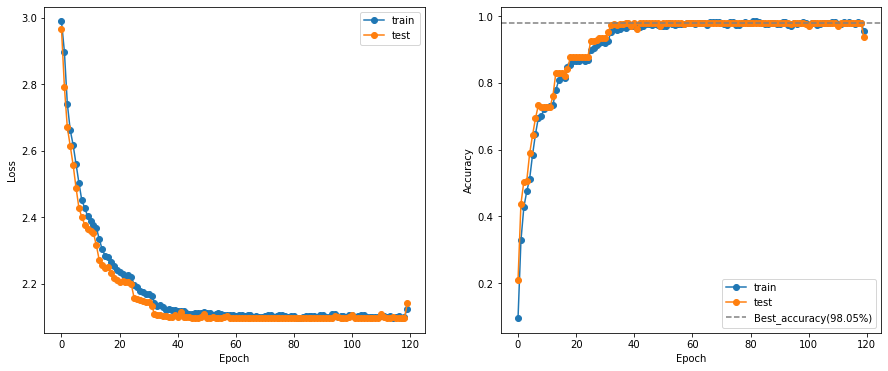

In [10]:

#model.to(device)
learning_rate = 0.001
epochs = 120

optimizer = optim.Adam(model.parameters(), lr= learning_rate)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
benchmark_accuracy = 0.40


for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    running_accuracy = 0
    running_loss = 0
    # training
    for x_train_batch, y_train_batch in trainloader:
        # x_train_batch = x_train_batch.to(device)
        # y_train_batch = y_train_batch.to(device)

        optimizer.zero_grad()

        # forward pass
        scores = model(x_train_batch)
        train_preds = torch.argmax(scores.detach(), dim=1)

        # loss
        train_loss = criterion(scores, y_train_batch)
        running_loss += train_loss.item()

        # train accuracy
        train_acc = (y_train_batch == train_preds).sum() / len(y_train_batch)
        running_accuracy += train_acc.item()

        # backward pass  
        train_loss.backward()
        
        # update paramaters
        optimizer.step()

    # mean loss (all batches losses divided by the total number of batches)
    train_losses.append(running_loss / len(trainloader))
    
    # mean accuracies
    train_accuracies.append(running_accuracy / len(trainloader))
    
    # print
    print(f'Train loss: {train_losses[-1] :.4f}')

    # validation
    model.eval()
    with torch.no_grad():
        running_accuracy = 0
        running_loss = 0

        for x_test_batch, y_test_batch in testloader:
            # x_test_batch = x_test_batch.to(device)
            # y_test_batch = y_test_batch.to(device)
            # logits
            test_scores = model(
                x_test_batch)

            # predictions
            test_preds = torch.argmax(test_scores, dim=1)
            
            # accuracy
            test_acc = (y_test_batch == test_preds).sum() / len(y_test_batch)
            running_accuracy += test_acc.item()

            # loss
            test_loss = criterion(test_scores, y_test_batch)
            running_loss += test_loss.item()

        # mean accuracy for each epoch
        test_accuracies.append(running_accuracy / len(testloader))

        # mean loss for each epoch
        test_losses.append(running_loss / len(testloader))
        # print
        print(f'Test accuracy: {test_accuracies[-1]*100 :.2f}%')
        print('='*100)
        # saving best model
        # is current mean score (mean per epoch) greater than or equal to the benchmark?
        if test_accuracies[-1] > benchmark_accuracy:
            # save model to cpu
            torch.save(model.state_dict(), MODEL_PATH)
            
            # bring back to gpu
           # model.to(device) 

            # update benckmark
            benchmark_accuracy = test_accuracies[-1]

    model.train()


# Plots
x_epochs = list(range(epochs))
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(x_epochs, train_losses, marker='o', label='train')
plt.plot(x_epochs, test_losses, marker='o', label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_epochs, train_accuracies, marker='o', label='train')
plt.plot(x_epochs, test_accuracies, marker='o', label='test')
plt.axhline(benchmark_accuracy, c='grey', ls='--',
            label=f'Best_accuracy({benchmark_accuracy*100 :.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(LRNG_CURVE_PATH, dpi = 200)

plt.show()